# Create Figures

This notebook will explain how to create figures using the code provided in this repository.

## Before you start

NOTE: To create the figures below and the figures from the paper, you will need to first download the ITP data files for [ITP2](https://www2.whoi.edu/site/itp/data/completed-missions/itp-2/itp-2-final-data/) and [ITP3](https://www2.whoi.edu/site/itp/data/completed-missions/itp-3/itp-3-final-data/) from the Woods Hole Oceanographic Institution (WHOI). "The Ice-Tethered Profiler data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution (https://www2.whoi.edu/site/itp/)." Download the "Level III 1-Hz processed profile data in MATLAB format" which have filenames like `itpXcormat.tar.Z` or `itpXcormat.zip`. Unzip the files and arrange them into the following directory structure:
```
`ITPs/`
    |
    -> `itp2/`
            |
            -> `itp2cormat/`
                            |
                            -> `cor0001.mat`
                            -> `cor0002.mat`
                                ...
                            -> `cor0244.mat`
    -> `itp3/`
            |
            -> `itp3cormat/`
                            |
                            -> `cor0001.mat`
                            -> `cor0002.mat`
                                ...
                            -> `cor1532.mat`
```

In the `make_netcdf.py` script, change the variable `science_data_file_path` to be the string for the absolute path to the directory which contains your `ITPs` folder. This will tell the script where to look for the original data files. Then run the following scripts in this order:
* `make_netcdf.py`
* `take_moving_average.py`
* `cluster_data.py`

Depending on your computer, these might take a while to run, especially `cluster_data.py`, but for all of the plots in this notebook, you will only need to run them once. When completed, there will be two netcdf files `ITP_2.nc` and `ITP_3.nc` in the newly created `netcdfs/` sub-directory. All of the plotting functions here will use data that is stored in these netcdf files.

#### `make_netcdfs.py`

This script takes data files from ocean profilers and converts them into netcdf files, one for each instrument. Note that, for netcdf files, in order to add a new variable, you must completely re-create the file, there is no way to add a variable to an existing file. To see the variables that one of these netcdfs will contain, see the `nc_vars` dictionary inside the `read_instrmt()` function. 

This script is currently set up to read the Level III 1-Hz processed profile data in MATLAB format from ITP2 and ITP3, but you can add as many other ITPs as you would like, following the calls to `read_instrmt()` at the bottom of the script. The Level III 1-Hz processed profile data is the full ~25 cm resolution captured by ITPs. The `make_netcdfs.py` script can also read and make netcdf files from the Level III 1-db bin-averaged processed profile data in ASCII format, but the binning process reduces the vertical resolution, washing away some of the fine-scale structure of staircases, and therefore isn't recommended for use with the staircase clustering detection algorithm.

#### `take_moving_average.py`

This script takes netcdf files that have been created by `make_netcdfs.py` and adds values into the following moving average variables: `ma_iT`, `ma_CT`, `ma_PT`, `ma_SP`, `ma_SA`, and `ma_sigma`. The variable `c3` is the value of the rectangular moving average window ($\ell$) in dbar. It is currently set to 100 dbar, following the study. This script is separate from `make_netcdfs.py` to allow for the flexibility to change the value of $\ell$, which is relatively quick, without having to re-create the entire netcdf, which takes a bit of time.

This script will also automatically update some of the global parameters, which keep track of changes and settings for a netcdf. To see an example of the global attributes in a netcdf, run the following cell:

In [ ]:
# For custom analysis functions
import analysis_helper_functions as ahf
# Create a dataset from one of the netcdf files
ds_ITP2_all = ahf.Data_Set({'ITP_2':'all'}, ahf.Data_Filters())
# Print out the global attributes
g_attrs = ahf.print_global_variables(ds_ITP2_all)

#### `cluster_data.py`

This script takes netcdf files that were created by `make_netcdfs.py` and have been modified by `take_moving_average.py` and runs the HDBSCAN clustering algorithm, recording the results to the netcdf files. You do not need to run this script in order to cluster data. As will be covered later, the plotting scripts can run HDBSCAN at the time of plotting. However, running HDBSCAN over large amounts of data can take a long time. Therefore, if you run the `cluster_data.py` script with the input parameters you plan on using for many plots, you won't need to re-run the algorithm every time you plot as the script will be able to pull the clustering results from the netcdf files.

The `cluster_data.py` script is currently set up to cluster ITP2 and ITP3 with the same parameters as the study. These are specified in the clustering dictionaries in the file. For example:

In [ ]:
## Reproducing figures from Timmermans et al. 2008
ITP2_clstr_dict = {'netcdf_to_load':'netcdfs/ITP_2.nc',
                   'sources_dict':{'ITP_2':'all'},
                   'data_filters':ahf.Data_Filters(),
                   'SP_range':[34.05,34.75],
                   'cl_x_var':'SP',
                   'cl_y_var':'la_CT',
                   'm_pts':170
                   }

All of the elements of this dictionary will be explained in more detail in following sections, but for a quick explanation: The `netcdf_to_load` is the relative path to the netcdf to load, `sources_dict` is the dictionary of sources to include, `data_filters` is the `Data_Filters` object to use, `SP_range` is the range of practical salinity to filter to, `cl_x_var` and `cl_y_var` are the x and y variables to use to create the spatial arrangement to cluster on, and `m_pts` is the one input parameter required by HDBSCAN which sets a threshold on the minimum points per cluster.

---

## Preparing to plot

First, run this cell to import the packages needed for this notebook to run:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

The next step is to import the `analysis_helper_functions.py` script:

In [2]:
# For custom analysis functions
import analysis_helper_functions as ahf

The `analysis_helper_functions.py` script imports many standard and not-so-standard Python packages. It contains all of the functions and class definitions needed to create these figures. If you get errors from running the above import, make sure you install all the relevant packages listed in the import statements in that file. If you don't plan on making detailed maps, you can comment out the lines importing from `cartopy`. Under the section "Figure 1", I explain how to visualize geographical distributions without `cartopy`. 

Next, we create a set of custom plotting objects.

### Plotting objects

The plots that can be generated from this script are very customizable. It works 
by creating different instances of custom objects which can be combined to make
different types of plots. The objects that are created are, in order:
* `Data_Filters`
    * A set of rules to broadly filter the data
* `Data_Set`
    * Contains the data to be plotted
* `Profile_Filters`
    * A set of rules on how to filter individual profiles
* `Plot_Parameters`
    * A set of rules on how to plot the data
* `Analysis_Group`
    * Wraps the other objects, contains the information to make one subplot

The `Data_Filters`, `Data_Set`, `Profile_Filters`, and `Plot_Parameters` can be combined
in many different ways. For example, if you want to plot the same data in many 
different ways, you can make one `Data_Set` object and combine it with many different
`Plot_Parameters` objects. Or, if you want to compare many different data sets by 
make many of the same type of plot, you can make many `Data_Set` objects and combine
each with the same `Plot_Parameters` object.

#### Data Filters

A data filter object broadly filters the data based on 4 parameters:
* `keep_black_list`
    * Whether or not to include profiles that have been placed on the black list
        * Currently, none of the profiles for ITP2 or ITP3 are on this list
    * Default: `False`, to automatically disclude profiles on the black list
* `cast_direction`
    * Which directions of casts to include, either `up`, `down`, or `all`
    * Default: `up`, to disclude down-going profiles because of the wake problem
* `geo_extent`
    * Whether to filter to just profiles within a certain geographical region
        * `CS` for Chukchi Sea, `SBS` for Southern Beaufort Sea, `CB` for Canada Basin, `MB` for Markov Basin, `EB` for Eurasian Basin, `BS` for Barents Sea, or `None` for no geographical restrictions
    * Default: `None` to include all profiles available
* `date_range`
    * A list of two dates where only profiles that were taken between the two will be kept
        * `['start_date', 'end_date']` where the dates are strings in the format `YYYY/MM/DD` or `None` to keep all profiles
    * Default: `None` to include all profiles available

For the figures we will make below, we will create a `Data_Filters` object with all the default parameters, so no arguments are needed:

In [3]:
dfs0 = ahf.Data_Filters()

#### Data Sets

A `Data_Set` object contains the dictionary of sources to pull data from and an array of `xarray` data sets from those sources with the filters from a `Data_Filters` object applied upon creation of the `Data_Set` object. 

The dictionary passed to the `Data_Set` follows the format `{'source1_filename':'pfs_to_keep', 'source2_filename':'pfs_to_keep'}` where the source filenames are strings of the netcdf files you wish to include (without the `.nc`) and the `pfs_to_keep` are either lists of specific profile numbers or `all` to include all profiles from that source. 

Below are examples of source dictionaries for all profiles in multiple files, all profiles in just one file, and just some profiles in a file:

In [4]:
# All profiles from all ITPs in this study
all_ITPs = {'ITP_2':'all','ITP_3':'all'}

# All profiles from certain ITPs
ITP2_all  = {'ITP_2':'all'}
ITP3_all  = {'ITP_3':'all'}

# Some specific profiles
ITP2_pfs  = {'ITP_2':[183, 185, 187]}

Note: If you are hoping to make a plot of specific profiles but wish to rerun the clustering algorithm on a larger dataset, you should include all the profiles in your source dictionary. There are options to specify specific profiles to actually plot in the Plot Parameters objects, but the clustering algorithm will be run on the data you include here.

Now, we can use those dictionaries to create data set objects:

In [5]:

ds_all_ITPs = ahf.Data_Set(all_ITPs, dfs0)

ds_ITP2_all = ahf.Data_Set(ITP2_all, dfs0)
ds_ITP3_all = ahf.Data_Set(ITP3_all, dfs0)

ds_ITP2_pfs = ahf.Data_Set(ITP2_pfs, dfs0)

#### Profile Filters

A `Profile_Filters` object will filter what data you will include but, unlike a data filters object, it can filter out specific points within specific profiles. The filter options are as follows:
* Filtering on the vertical
    * `p_range`: a range of pressures (dbar), `[p_min, p_max]`
    * `d_range`: a range of depths (m), `[d_min, d_max]`
* Filtering on temperature
    * `iT_range`: a range of insitu temperatures ($^\circ$C), `[iT_min, iT_max]`
    * `CT_range`: a range of conservative temperatures ($^\circ$C), `[CT_min, CT_max]`
* Filtering on salinity
    * `SP_range`: a range of practical salinities (g/kg), `[SP_min, SP_max]`
    * `SA_range`: a range of absolute salinities (g/kg), `[SA_min, SA_max]`
* Subsample each profile, `subsample`
    * Either `True` or `False` as to whether to apply the subsample mask which can be added to a netcdf by running the `subsample_netcdf.py` script
* Regrid temperature and salinity, `regrid_TS`
    * Either `True` or `False` as to whether to regrid temperature and salinity onto a particular lower-resolution grid
* Re-run moving average, `m_avg_win`
    * A value in dbar for $\ell$ to use when running `take_m_avg()` before plotting
    * While `take_m_avg()` and `take_moving_average` do the same thing, the results of `take_m_avg()` are not recorded to any netcdf files

To recreate the plots in the study, we will only be filtering to ranges in practical salinity, so here we create those needed `Profile_Filter` objects:

In [6]:
# Define practical salinity ranges to use
ITP2_SP_range = [34.05, 34.75]
ITP3_SP_range = [34.21, 34.82]
# Create Profile_Filters objects
pfs_ITP2 = ahf.Profile_Filters(SP_range=ITP2_SP_range)
pfs_ITP3 = ahf.Profile_Filters(SP_range=ITP3_SP_range)
# Create a Profile_Filters object with the default filters
pfs_0 = ahf.Profile_Filters()

#### Plot Parameters

A `Plot_Parameters` object contains the necessary information to format one subplot. There are many parameters which can be contained in a `Plot_Parameters` object. Below are some of the most important, while other parameters that are very situation-specific will be explained as they appear in following sections.
* `plot_type`
    * What kind of plot to make, either `xy` (just two variables plotted against each other), `map`, or `profiles`
    * Defaults to `xy`
* `x_vars`
    * A list of up to two strings specifying the variables which will be on the x-axis (horizontal)
* `y_vars`
    * A list of up to two strings specifying the variables which will be on the y-axis (vertical)
* `legend`
    * Either `True` or `False` as to whether to include a legend on this subplot
* `ax_lims`
    * A dictionary containing the axis limits for the final plot
    * Ex: `{'x_lims':[x_min,x_max], 'y_lims':[y_min,y_max]}`
    * Note: only works for axes that have one variable
* `clr_map`
    * A string specifying the colormap to use for the data
    * Options include: 
        * `clr_all_same` colors every point a standard color
            * This is the default option 
        * `clr_by_source` colors data from each source a different color
        * `clr_by_instrmt` colors data from each instrument a different color
        * `density_hist` makes a 2D histogram with the color-scale representing the density of points in the chosen variable space
        * `cluster` colors each point by the cluster it was put in, or as noise
        * Any regular variable string, which will color the points on the scale of the chosen variable
* `extra_args`
    * A catch-all dictionary for parameters that are only used in specific circumstances

The following is an example `Plot_Parameters` object which will plot practical salinity versus conservative temperature with a color map of pressure:

In [7]:
pp_test0 = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], legend=True, clr_map='press')

#### Analysis Groups

As the analysis groups contain the data to plot and the rules by which to plot the data, each analysis group represents a subplot. They accept the following arguments:
* `data_set`
    * A `Data_Set` object, as described above
* `profile_filters`
    * A `Profile_Filters` object, as described above
* `plt_params`
    * A `Plot_Parameters` object, as described above
* `plot_title`
    * An optional argument, a string of what the subplot's title will be
    * If none is given, the plot will have a standard title which depends on the type of plot

Here, we create two analysis groups, one for ITP2 and ITP3, but both using the same profile filters and plot parameters:

In [8]:
group_ITP2_test0 = ahf.Analysis_Group(ds_ITP2_all, pfs_0, pp_test0)
group_ITP3_test0 = ahf.Analysis_Group(ds_ITP3_all, pfs_0, pp_test0)

- Applying profile filters
- Applying profile filters


### Making a figure

Between 1 and 9 analysis groups can be combined using the `make_figure()` function to produce a plot, either
as an image in the GUI, an image file, or a pickle file. The arguments it accepts are as follows:
* `groups_to_plot`
    * A list of `Analysis_Group` objects to plot
    * Note, you still must give a list even if it only has one `Analysis_Group`
    * The order of this list determines the order of the subplots
* `filename`
    * If given a file name that ends in `.png` or `.pickle`, the plot will be saved to that file
    * If no file name is given, the plot will appear in the matplotlib GUI
* `use_same_x_axis` and `use_same_y_axis`
    * Used to override automatically sharing x or y axes when neighboring subplots have the same variables on the same axis
* `row_col_list`
    * Can be used to specify a different row/column arrangement and figure aspect ratio/size than the defaults

Below, we plot the test plots of practical salinity $S_P$ versus conservative temperature $\Theta$ for ITP2 and ITP3:

	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


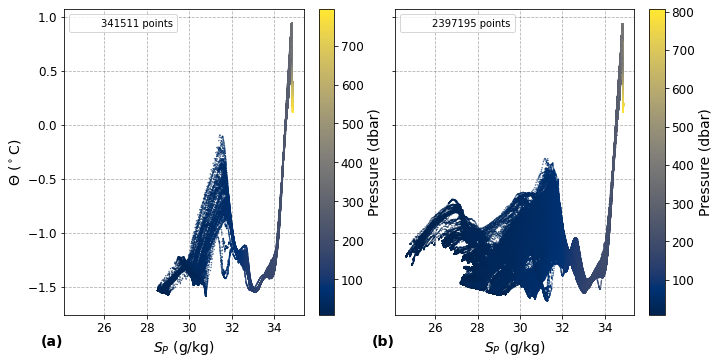

In [9]:
# Make the figure
ahf.make_figure([group_ITP2_test0, group_ITP3_test0])

Notice how the output includes the lines:
```
	- Set share_x_axis to True
	- Set share_y_axis to True
```
This means the code recognized that both subplots had the same variables on the x and y axes, respectively. Therefore, it set the axis bounds to be the same for both such that the larger bounds override smaller ones. The range in $S_P$ for ITP3 has a much lower bound than ITP2. Note, however, that the bounds on the colorbars are not automatically shared.

---

## Figure 1

Figure 1 from the study is a map which shows the locations for all the up-going profiles from ITP2 and ITP3. 

### Getting set up with Cartopy

The `map` plot type requires the `cartopy` package to be installed. As noted right before the import command in `analysis_helper_functions.py`, the installation instructions can be found in the [Cartopy docs](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing) and the relevant command is:

```
$ conda install -c conda-forge cartopy
```

However, this just installs the Python package. In order to make the maps, you will also need to download the relevant shape files. The following steps will give you an idea on how to get things set up to actually make maps, but can be difficult and require a bit of debugging. If you don't need good looking maps and just want to plot rough geographical distributions, skip to the `Plotting Longitude vs. Latitude` section.

The relevant shape files are from Natural Earth, the [1:50m Physical Vectors](https://www.naturalearthdata.com/downloads/50m-physical-vectors/) and [1:10m Bathemetry](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-bathymetry/). However, the Natural Earth server is prone to issues with downloads, so the files can also be found GitHub user
[nvkelso's natural-earth-vector repository](https://github.com/nvkelso/natural-earth-vector/tree/master/10m_physical/ne_10m_bathymetry_all).

In oder to figure out where to put the files, run the following commands:

In [ ]:
import cartopy
cartopy.config['data_dir']

This will output the location for where Cartopy stores files. From that `cartopy` directory it points to, go down the subdirectory `shapefiles/natural_earth/physical`, or make that subdirectory if it doesn't already exist. Then, put all of the shape files into that `physical` directory flat, meaning not inside any other subdirectories. Note that all the files need to have the prefix `ne_` in order to work.

### Plotting with Cartopy

The following code block makes the `Plot_Parameter` and `Analysis_Group` objects needed to recreate Figure 1 from the study. Here, the `make_figure()` function has been called with a file name that ends in `.pickle` which will save the plot to a pickle object file within the `outputs/` directory. Pickling is a way to save a figure so that you can re-plot it later.

In [ ]:
### Figure 1
## Map of ITP drifts for ITP2 and ITP3
# Make the Profile Parameters
pp_ITP_map = ahf.Plot_Parameters(plot_type='map', clr_map='clr_by_instrmt')
pp_ITP_map_full_Arctic = ahf.Plot_Parameters(plot_type='map', clr_map='clr_by_instrmt', extra_args={'map_extent':'Full_Arctic'}, legend=False)
# Make the Analysis Groups
group_ITP_map = ahf.Analysis_Group(ds_all_ITPs, pfs_0, pp_ITP_map, plot_title='')
group_ITP_map_full_Arctic = ahf.Analysis_Group(ds_all_ITPs, pfs_0, pp_ITP_map_full_Arctic, plot_title='')
# Make the figure
ahf.make_figure([group_ITP_map_full_Arctic, group_ITP_map], use_same_x_axis=False, use_same_y_axis=False, filename='Figure_1.pickle')

By pickling a figure into a file, this means you can recall it into the matplotlib GUI later without having to go through the pre-calculations necessary to plot. This can save time for figures that take particularly long to generate and allow you to make the subtle adjustments possible within the GUI again or save the image in a different file format without having to re-run the whole code. In order to do this from a command prompt, run a command like:
```
$ python3 unpickle.py outputs/Figure_1.pickle
```

Or, to do so from this notebook, run:

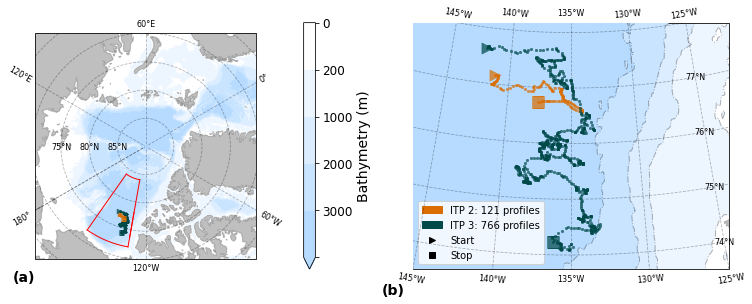

In [10]:
import dill as pl
fig = pl.load(open('outputs/Figure_1.pickle', 'rb'))
plt.show()

### Plotting Longitude vs. Latitude

This section shows how you can plot the geographic distribution of your data without having to use Cartopy. This allows you to avoid that installation and also provides a much quicker way to visualize how data is arranged in geographic space.

Essentially, this involves just making an `xy` plot, but using `lon` and `lat` as the x and y axes. By using the `clr_by_instrmt` color map, the points from ITP2 and ITP3 will be different colors:

In [ ]:
# Make the Plot Parameters
pp_lat_lon_test = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], legend=True, clr_map='clr_by_instrmt')
# Make the Analysis Group
group_lat_lon_test = ahf.Analysis_Group(ds_all_ITPs, pfs_0, pp_lat_lon_test)
# Make the figure
ahf.make_figure([group_lat_lon_test])

---

## Figure 2

Figure 2 from the study reproduces several figures from Timmermans et al. 2008, but adds in the results of the clustering algorithm.

### Axis limits

In order to reproduce the figures from Timmermans et al. 2008, we want to use the same axis limits as they did. We can do this by defining dictionaries which will be input to the `ax_lims` argument in the `Plot_Parameters` objects. The dictionaries can contain x limits, y limits, or both.

In [11]:
# Timmermans et al. 2008 Figure 4 depth range
T2008_fig4_y_lims = {'y_lims':[260,220]}
# Timmermans et al. 2008 Figure 5 x and y limits
T2008_fig5a_ax_lims = {'x_lims':[34.05,34.75], 'y_lims':[-1.3,0.5]}
# Timmermans et al. 2008 Figure 5 x limits
T2008_fig5a_x_lims = {'x_lims':[34.05,34.75]}
# Timmermans et al. 2008 Figure 6 x and y limits
T2008_fig6a_ax_lims = {'x_lims':[0.026838,0.026878], 'y_lims':[-13e-6,3e-6]}

In making the `Plot_Parameters` objects for Figure 2, we will illustrate how to set a number of options for the plots. 

### General arguments 

Some other general arguments that can be set for each plot:
* `legend` to determine whether or not to have a legend
    * Default: `True`
* `add_grid` to determine whether or not to have grid lines
    * Default: `True`

In the following examples, these arguments are set only when we want the plot to have different settings than the defaults, for example:

In [12]:
# Reproducing Timmermans et al. 2008 Figure 4, with cluster coloring and 2 extra profiles
pp_T2008_fig4  = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['press'], plot_type='profiles', clr_map='cluster', ax_lims=T2008_fig4_y_lims)
# The actual clustering done for reproducing figures from Timmermans et al. 2008
pp_T2008_clstr = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['la_CT'], clr_map='cluster', ax_lims=T2008_fig5a_x_lims, legend=False)

### Extra arguments

Next, are a set of arguments that can be specified within the `extra_args` dictionary:
* `isopycnals` for plotting lines of constant density
    * Default: `False`
* `place_isos` for specifying how to place the in-line labels for the isopycnals
    * Default: automatic
* `plt_noise` for specifying whether or not to plot noise points
    * Default: `True`
* `plot_slopes` to determine whether or not to add slope lines to the plot
    * Default: `False`

#### Isopycnal lines

You can specify whether or not to add isopycnal lines (lines of constant density) to a plot by adding `isopycnals` to the `extra_args` dictionary. The value for the `isopycnals` key specifies the pressure at which to reference the isopycnals. If you want to plot isopycnals in $\alpha\Theta$-$\beta S_P$ space, set the key to `True`. But, for example, if you set the value to `0`, it will reference to the surface, which is what we will do to reproduce Figure 5a from Timmermans et al. 2008:

In [13]:
# Reproducing Timmermans et al. 2008 Figure 5a, but with cluster coloring
pp_T2008_fig5a = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='cluster', extra_args={'isopycnals':0, 'plt_noise':False}, ax_lims=T2008_fig5a_ax_lims, legend=False)

The isopycnals will only be added to plots where it make sense, namely T-S plots. If the `isopycnals` argument isn't given or it wouldn't make sense on the specified plot, isopycnals will not be added. There is also the `place_isos` argument that can be added to the `extra_args` dictionary. If you add it with the value `manual`, then the GUI will appear as the figure is being built, prompting you to specify where on the isopycnal lines to add the in-line labels. You can left click where you want the labels to show up and when you're done, use the middle mouse click to let the code finish running.

#### Plotting noise points

Another argument that can be added to `extra_args` is `plt_noise`. If the value is `True`, it will add the noise points to a plot which is colored by cluster. If `False`, it will skip plotting the noise points and only plot points within clusters. By default, `plt_noise` is set to `True`, but for the reproduction of Timmermans et al. Figure 5a, we don't want to see the noise points, so we set that to `False`. 

### Plotting slopes

The argument `plot_slopes` inside the `extra_args` dictionary will do slightly different things depending on the plot. Generally, it will use orthogonal distance regression (found in the `orthoregress.py` file provided by [Robin Wilson](https://blog.rtwilson.com/orthogonal-distance-regression-in-python/)) to plot a linear best fit line through the points. If the color map is `cluster`, it will find a different line for each cluster. However, if you use this argument for a plot on cluster averaged pressure vs. lateral density ratio $R_L$, it will fit to a 2nd degree polynomial, which can be seen in Figure 4. Here, for Figure 2, we use it to find linear best fit lines in $\alpha\Theta$-$\beta S_P$ space, the inverse slopes of which are the $R_L$ values for each cluster:

In [14]:
# Reproducing Timmermans et al. 2008 Figure 6a, but with cluster coloring
pp_T2008_fig6a = ahf.Plot_Parameters(x_vars=['BSP'], y_vars=['aCT'], clr_map='cluster', extra_args={'plot_slopes':True, 'isopycnals':True}, ax_lims=T2008_fig6a_ax_lims, legend=False)

Now, we can make Figure 2. Note, when plotting in Jupyter notebooks, the borders for this figure are extremely large. If you plot it to a file, it looks fine.

- Applying profile filters
- Applying profile filters
- Applying profile filters
- Applying profile filters
- Subplot a
setting b_a_w_plt to false
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
box_and_whisker: False
	- Adding isopycnals referenced to: 0 dbar
	- Set x_lims to [34.05, 34.75]
	- Set y_lims to [-1.3, 0.5]
	- Adding grid lines: True
- Subplot b
setting b_a_w_plt to false
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Profiles to plot: [183. 185. 187.]
	- Inverting y-axis-
	- Set y_lims to [260, 220]
	- Adding grid lines: True
- Subplot c
setting b_a_w_plt to false
	- Re-run HDBSCAN

/Users/Grey/Documents/Research/PhD_Projects/Project_1-Staircase_detection/Staircase_Clustering_Detection_Algorithm/analysis_helper_functions.py:1559: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=0.4, h_pad=tight_layout_h_pad, w_pad=tight_layout_w_pad)


- Saving figure to outputs/test_fig2.png


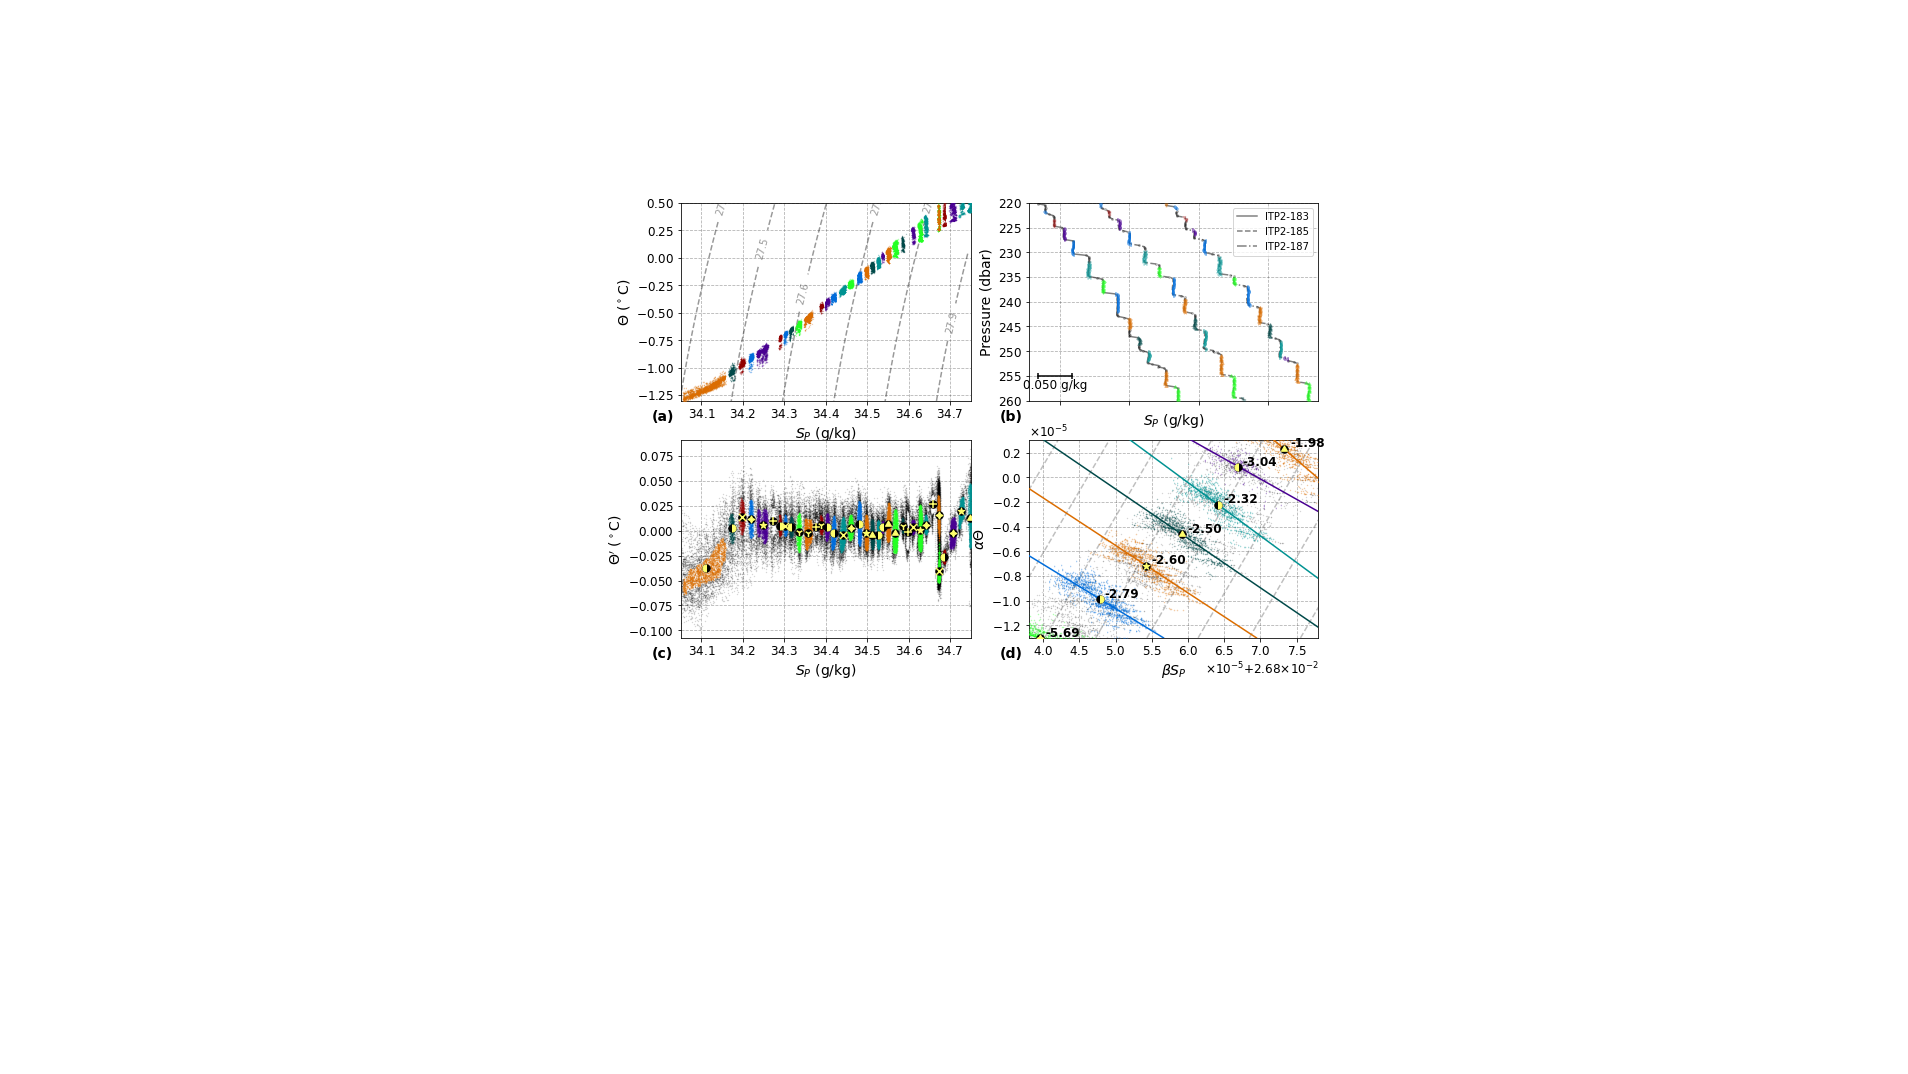

In [15]:
### Figure 2
## Using ITP2, reproducing figures from Timmermans et al. 2008
# Make the Analysis Groups
group_T2008_clstr = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_T2008_clstr, plot_title='')
group_T2008_fig4  = ahf.Analysis_Group(ds_ITP2_pfs, pfs_ITP2, pp_T2008_fig4,  plot_title='')
group_T2008_fig5a = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_T2008_fig5a, plot_title='')
group_T2008_fig6a = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_T2008_fig6a, plot_title='')
# Make the figure
ahf.make_figure([group_T2008_fig5a, group_T2008_fig4, group_T2008_clstr, group_T2008_fig6a], filename='Figure_2.png')

---

## Figure 3

Figure 3 from the study shows two parameter sweeps as an example of how to select values of $\ell$ and $m_{pts}$.
